<a href="https://colab.research.google.com/github/GurpreetUppal/Multifaceted-Obesity-Prediction/blob/main/KModes_customer_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-clustering-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4694456%2F7976778%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T204802Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D15ec705984eaab9bc50e1b90fbb7cdd28c8e9b3a17e904e084b30f287c69aa31fa428e06bc2daa7852842fcb83f8c0f6fc10676e1c098b16f655955c93646ad5a6861b2cd4241df8c1d59f0f0298d0abf41ccb505cee9a35fb70cd479a2ff715a5f8f3e75938ef58b93d2ab54cc88b6d392ade538f0f820936ede794ca3e65179e86659535401684dd1ea4cdf9bbed4ab1ae77ec8d4560296e73fa66fb2207e038452578bee43aff6a7591450d7458185be623197e4bddc647e360809e31533fb7b28f03cf35318f8ffc9b32ce1f189f3940bd7f58d8440c91177159dfde72b6756b4a5b47f6ae38ce8d9aa30c3ebd71add2cdefd30e171a1efb58585c2f77f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 48205 bytes downloaded
Downloaded and uncompressed: customer-clustering-data
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder
pallete = sns.color_palette("Set2")
pd.set_option('display.max_columns',None)

In [ ]:
customer_df = pd.read_csv('/kaggle/input/customer-clustering-data/Tires Data kaggle.csv')
customer_df.head()

,Age Group,Neighbourhood,Education,Household income,Discount Code,Discount code obtained,High Qual Rim Last 5 Yrs,Household Size,Last Date of all seasons purchase,Last Date of summer purchase,Last Date of winter purchase,Primary Vehicle,Responded August Promo (all-season tires),Responded March promo (all seasons),Responded March Promo (summer tires),Responded November promo (winter tires),Responded October Promo (winter tires),Warranty Purchased,All Seasons Tires Sales,Instore Sales,Num Adult Drivers,Num Adults,Num Child 18 and Under,Num Young Drivers,Number of vehicles in household,Online Sales,Rough/Approx km per year,Services at Other Retailers,Summer Tires Sales,Total Drivers,Wheel/rim purchase,Winter Tires Sales
0,60-70,Kelowna,Bachelors,$32K - $55K,30% off on next purchase,Online,Aluminum,Dual Household,10/17/2022,9/26/2019,10/30/2021,Compact,N,Y,N,Y,N,N,1,7,2,2,0,0,2,4,21000,2,2,2,1,2
1,30-39,Kelowna,HS diploma,Less than $32K,30% off on next purchase,In Store,Aluminum,Single Household,7/23/2022,8/25/2021,8/13/2020,Truck,N,N,N,Y,N,N,1,0,1,1,0,0,1,2,14000,3,1,1,0,0
2,30-39,Penticton,HS diploma,Less than $32K,50% off on second set,In Store,Specialised,Dual Household,2/18/2022,4/9/2018,8/17/2021,SUV,N,N,Y,Y,N,Y,1,6,1,2,0,0,4,9,39000,2,0,1,4,0
3,20-29,Lake Country,HS diploma,$32K - $55K,20% off entire purchase,Online,Specialised,Multi Member Household,10/1/2021,7/5/2026,3/2/2022,Compact,N,N,N,N,Y,N,0,3,1,2,2,0,1,2,10000,7,0,1,2,1
4,30-39,Penticton,HS diploma,Less than $32K,30% off on next purchase,Online,Specialised,Single Household,2/22/2021,10/9/2016,9/14/2023,Mini Van,Y,N,N,N,Y,Y,0,5,1,1,0,0,2,5,14000,3,2,1,2,2


In [ ]:
customer_df.columns

Index(['Age Group', 'Neighbourhood', 'Education', 'Household income',
       'Discount Code', 'Discount code obtained', 'High Qual Rim Last 5 Yrs',
       'Household Size', 'Last Date of all seasons purchase',
       'Last Date of summer purchase', 'Last Date of winter purchase',
       'Primary Vehicle', 'Responded August Promo (all-season tires)',
       'Responded March promo (all seasons)',
       'Responded March Promo (summer tires)',
       'Responded November promo (winter tires)',
       'Responded October Promo (winter tires)', 'Warranty Purchased',
       'All Seasons Tires Sales', 'Instore Sales', 'Num Adult Drivers',
       'Num Adults', 'Num Child 18 and Under', 'Num Young Drivers',
       'Number of vehicles in household', 'Online Sales',
       'Rough/Approx km per year', 'Services at Other Retailers',
       'Summer Tires  Sales', 'Total Drivers', 'Wheel/rim purchase',
       'Winter Tires Sales'],
      dtype='object')

## Selecting variables for clustering

In [ ]:
#customer_df.columns
variables = ['Age Group','Education','Household income','Discount Code',
         'Winter Tires Sales']
cluster_df  = customer_df[variables]
cluster_df.head()

,Age Group,Education,Household income,Discount Code,Winter Tires Sales
0,60-70,Bachelors,$32K - $55K,30% off on next purchase,2
1,30-39,HS diploma,Less than $32K,30% off on next purchase,0
2,30-39,HS diploma,Less than $32K,50% off on second set,0
3,20-29,HS diploma,$32K - $55K,20% off entire purchase,1
4,30-39,HS diploma,Less than $32K,30% off on next purchase,2


## Label Encoding for kmode clustering

In [ ]:
le = LabelEncoder()
encoded_cluster_df = cluster_df.apply(le.fit_transform)
encoded_cluster_df

,Age Group,Education,Household income,Discount Code,Winter Tires Sales
0,4,0,1,1,2
1,1,4,5,1,0
2,1,4,5,2,0
3,0,4,1,0,1
4,1,4,5,1,2
...,...,...,...,...,...
1618,1,4,2,2,1
1619,1,2,6,1,1
1620,1,2,3,3,3
1621,1,2,4,3,0


## Apply Kmode clustering

In [ ]:
from kmodes.kmodes import KModes

kmodes_cao = KModes(n_clusters = 3, init = 'cao', n_init= 10, verbose = 0) # verbose = 1 to see the iterations
clusters = kmodes_cao.fit_predict(encoded_cluster_df)

clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [ ]:
cluster_df['clusters'] = clusters
cluster_df.head()

,Age Group,Education,Household income,Discount Code,Winter Tires Sales,clusters
0,60-70,Bachelors,$32K - $55K,30% off on next purchase,2,0
1,30-39,HS diploma,Less than $32K,30% off on next purchase,0,0
2,30-39,HS diploma,Less than $32K,50% off on second set,0,0
3,20-29,HS diploma,$32K - $55K,20% off entire purchase,1,0
4,30-39,HS diploma,Less than $32K,30% off on next purchase,2,0


## Selecting the best value of k for clustering

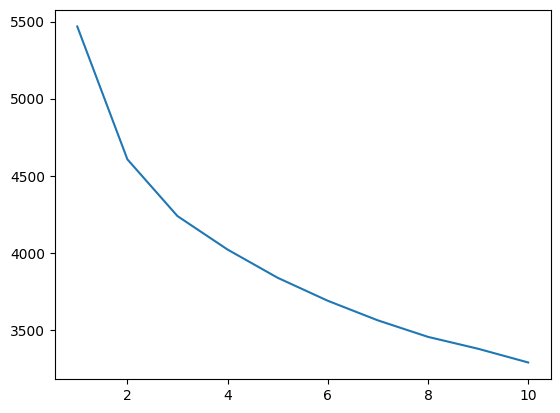

In [ ]:
cost=[]
for i in range(1,11):
    kmode = KModes(n_clusters = i, init = 'cao',n_init = 5, verbose = 0)
    kmode.fit_predict(encoded_cluster_df)
    cost.append(kmode.cost_)

plt.plot(np.arange(1,11), cost)

## Interpreting the clusters

<Axes: xlabel='clusters', ylabel='count'>

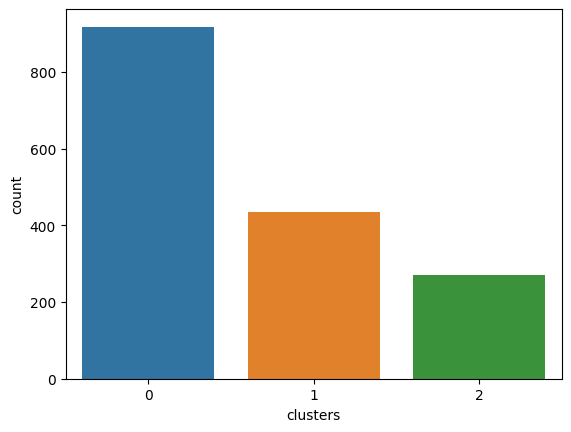

In [ ]:
sns.countplot(data = cluster_df, x = 'clusters' )

In [ ]:
cluster_df.columns

Index(['Age Group', 'Education', 'Household income', 'Discount Code',
       'Winter Tires Sales', 'clusters'],
      dtype='object')

In [ ]:
cluster_df['Household income'].unique()

array(['$32K - $55K', 'Less than $32K', '$99K  - $140K', '$75K - $99K',
       '$55K - $75K', '$140K - $ 200K', 'More Than  $200K'], dtype=object)

<Axes: xlabel='Age Group', ylabel='count'>

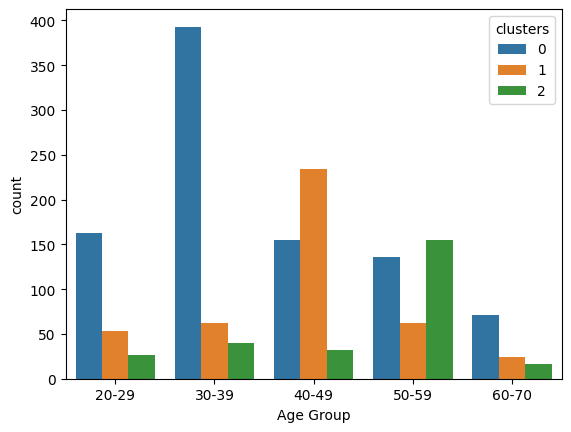

In [ ]:
sns.countplot(data = cluster_df, x ='Age Group', order = ['20-29','30-39','40-49','50-59','60-70'],hue = 'clusters' )

<Axes: xlabel='count', ylabel='Household income'>

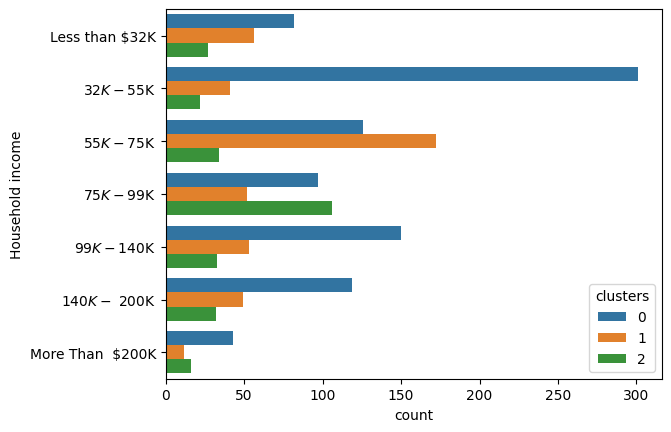

In [ ]:
sns.countplot(data = cluster_df, y = 'Household income', order= ['Less than $32K','$32K - $55K', '$55K - $75K','$75K - $99K', '$99K  - $140K','$140K - $ 200K', 'More Than  $200K'],hue = 'clusters')

<Axes: xlabel='count', ylabel='Discount Code'>

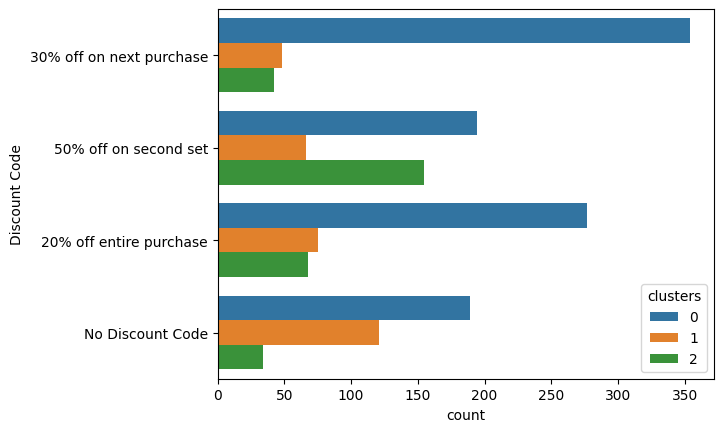

In [ ]:
sns.countplot(data = cluster_df, y = 'Discount Code' , hue = 'clusters')

<Axes: xlabel='Responded August Promo (all-season tires)', ylabel='count'>

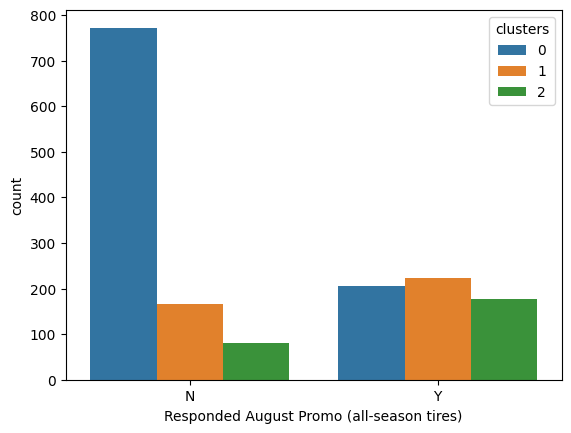

In [ ]:
sns.countplot(data = cluster_df, x =  'Responded August Promo (all-season tires)', hue = 'clusters')

<Axes: xlabel='Responded March Promo (summer tires)', ylabel='count'>

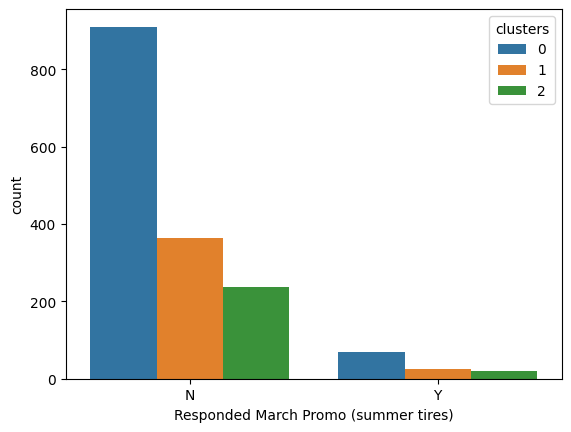

In [ ]:
sns.countplot(data = cluster_df, x = 'Responded March Promo (summer tires)', hue = 'clusters')

<Axes: xlabel='Responded March promo (all seasons)', ylabel='count'>

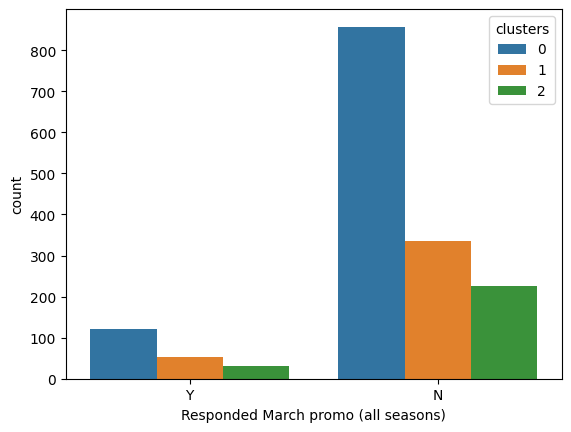

In [ ]:
sns.countplot(data = cluster_df, x = 'Responded March promo (all seasons)', hue = 'clusters')

<Axes: xlabel='Responded October Promo (winter tires)', ylabel='count'>

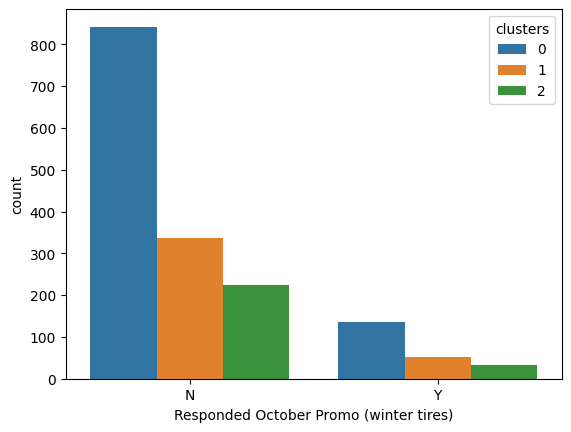

In [ ]:
sns.countplot(data = cluster_df, x = 'Responded October Promo (winter tires)', hue = 'clusters')

<Axes: xlabel='Services at Other Retailers', ylabel='count'>

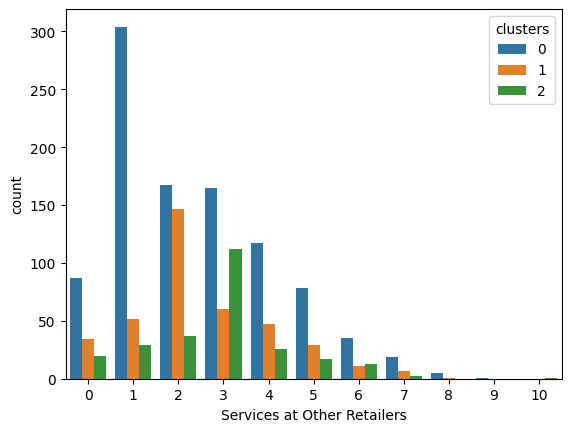

In [ ]:
sns.countplot(data = cluster_df, x ='Services at Other Retailers', hue = 'clusters')

## Customer Segmenatation


